In [1]:
using Pkg; Pkg.activate("..")
using Plots; pyplot()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
data_home = "../working_data/"

Activating environment at `~/GVFN/Project.toml`


┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at pyplot.jl:24
└ @ Core /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:24


"../working_data/"

In [2]:
Plots.scalefontsizes(1.5)

┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:935
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:935
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:937
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:937
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:938
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:938
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:939
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:939
┌ Warnin

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _before_layout_calcs(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1100
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:1100
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_set_axis_colors(::Plots.Subplot{Plots.PyPlotBackend}, ::PyCall.PyObject, ::Plots.Axis) at pyplot.jl:914
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:914
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_set_axis_colors(::Plots.Subplot{Plots.PyPlotBackend}, ::PyCall.PyObject, ::Plots.Axis) at pyplot.jl:9

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_bbox_axislabel(::PyCall.PyObject, ::String) at pyplot.jl:288
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:288
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_bbox_title(::PyCall.PyObject) at pyplot.jl:304
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:304
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_bbox_title(::PyCall.PyObject) at pyplot.jl:304
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:304
┌ Warning: `getindex(o::PyObject, s::Symbol)

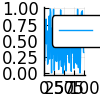

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _update_plot_object(::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1304
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:1304
┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = _show(::Base64.Base64EncodePipe, ::MIME{Symbol("image/png")}, ::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1343
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:1343
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _show(::Base64.Base64EncodePipe, ::MIME{Symbol("image/png")}, ::Plots.Plot{Plots.PyPlotBackend}) at pyplot.jl:1343
└ @ Plots /home/andrew/.julia/packages/Plots/gylTh/src/backends/pyplot

In [3]:
# Get the stupid pyplot warnings out of the way
p=plot(rand(100))
plot(p, size=(100,100))

In [4]:
# ==================
# --- DATA UTILS ---
# ==================

function NRMSE(results; phase="Validation", window=10000,skip=10)
    # Ground truth and predictions
    g,p = results["$(phase)GroundTruth"], results["$(phase)Predictions"]

    # drop the extra predictions past the last ground truth
    p = p[1:length(g)]

    # subsample the data for efficiency
    #g, p = g[1:skip:end], p[1:skip:end]

    values = Float64[]
    for i=window+1:skip:length(p)
        ĝ = g[i-window:i]
        P̂ = p[i-window:i]
        push!(values, sqrt(mean((ĝ.-P̂).^2) / mean((ĝ.-mean(ĝ)).^2)))
    end
    return values
end

TrainingNRMSE(results) = NRMSE(results; phase="")
ValidationNRMSE(results) = NRMSE(results; phase="Validation")
TestNRMSE(results) = NRMSE(results; phase="Test")

loadData(itm) = load(joinpath(itm.folder_str,"results.jld2"))["results"]

function get_setting(ic, clean_func)

    diff_dict = diff(ic)
    
    itms = ic.items
    res = Vector{Float64}[]
    for (itm_idx, itm) ∈ enumerate(itms)
        push!(res, clean_func(loadData(itm)))
    end
    
    vals = zeros(length(res[1]),length(res))
    for i=1:length(res)
        vals[:,i] .= res[i]
    end
    
    μ = mean(vals,dims=2)
    σ = std(vals, dims=2, corrected=true)./sqrt(length(itms))
    
    return μ, σ
end

function get_best_setting(ic::ItemCollection, params::Dict)
    sub_ic = ItemCollection(search(ic, params)[3])
    
    sub_diff = diff(sub_ic)
    delete!(sub_diff, "seed")
    
    iter = Iterators.product(values(sub_diff)...)
    best = Inf
    bestIC = nothing
    bestData = nothing
    for arg ∈ iter
        ic′ = ItemCollection(search(sub_ic, Dict(Pair.(keys(sub_diff),arg)))[3])
        μ,_ = get_setting(ic′, ValidationNRMSE)
        
        μ = mean(μ)
        if μ ≤ best
            best = μ
            bestIC = ic′
        end
    end
    @assert best != Inf
    
    return get_setting(bestIC, TrainingNRMSE)
end


get_best_setting (generic function with 1 method)

In [5]:
# ==================
# --- PLOT UTILS ---
# ==================

struct PlotSpec
    ic::ItemCollection
    model::String
    key::String
    smoothing_window::Int
end

function plot_best_settings(spec::PlotSpec)
    ic = spec.ic
    d = diff(ic)
    
    model = spec.model
    τkey = spec.key
    
    p=plot()
    for τ ∈ diff(ic)[τkey]
        μ,σ = get_best_setting(ic, Dict(τkey=>τ))
        
        if spec.smoothing_window > 1
            μ, σ = begin
                
                sm = Float64[]
                smσ = Float64[]
                window=spec.smoothing_window
                for i=1:window:length(μ)-window
                    push!(sm, mean(μ[i:i+window]))
                    push!(smσ, mean(σ[i:i+window]))
                end
                sm, smσ
            end
        end
        
        xvals = collect(1:length(μ))
        plot!(p, xvals, μ, ribbon=σ; label="$(model) τ=$τ", ylabel="NRMSE", xlabel="Steps")
    end
    return p
end

plot_best_settings (generic function with 1 method)

In [ ]:
ic = ItemCollection("../mackeyglass_gvfn_best/data")
μ, σ = get_setting(ic, TrainingNRMSE)
plot(μ, ribbon=σ)

---
# MackeyGlass
---

In [20]:
RNNSpec(ic; window=10) = PlotSpec(ic, "RNN", "tau", window)
GVFNSpec(ic; window=10) = PlotSpec(ic, "GVFN", "tau", window)

GVFNSpec (generic function with 1 method)

In [21]:
gvfn_ic = ItemCollection(joinpath(data_home,"mackeyglass_fluxgvfn/data"));
diff(gvfn_ic)

Dict{String,Array} with 5 entries:
  "opt"      => ["Descent", "RMSProp"]
  "stepsize" => [9.53674e-7, 1.90735e-6, 3.8147e-6, 7.62939e-6, 1.52588e-5, 3.0…
  "seed"     => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "tau"      => [1, 2, 4, 8, 16, 32]
  "num_gvfs" => [32, 64, 128]

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_add_series(::Plots.Plot{Plots.PyPlotBackend}, ::Plots.Series) at pyplot.jl:823
└ @ Plots /home/ubuntu/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:823
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_add_legend(::Plots.Plot{Plots.PyPlotBackend}, ::Plots.Subplot{Plots.PyPlotBackend}, ::PyCall.PyObject) at pyplot.jl:1247
└ @ Plots /home/ubuntu/.julia/packages/Plots/gylTh/src/backends/pyplot.jl:1247


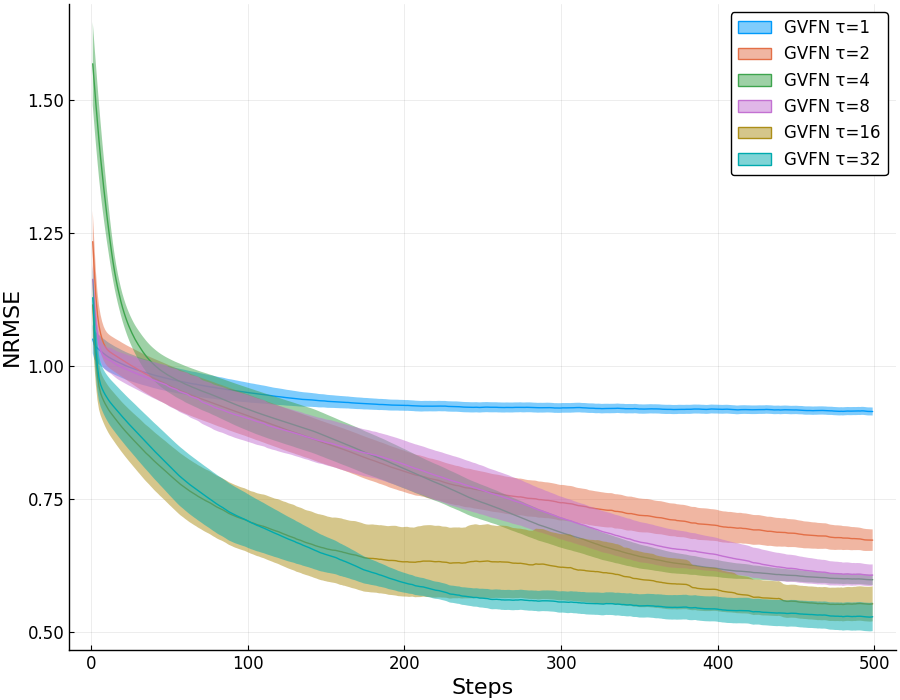

In [22]:
p = plot_best_settings(GVFNSpec(gvfn_ic; window=10))
plot(p, size=(900,700))

In [23]:
#rnn_ic = ItemCollection(joinpath(data_home,"mackeyglass_fluxrnn/data"));
#diff(rnn_ic)

In [24]:
#μ,σ = get_best_setting(rnn_ic, Dict("tau"=>2))
#plot(μ, ribbon=σ, label="RNN τ=1", ylabel="NRMSE", xlabel="Steps")

---
# ACEA 
---

In [25]:
RNNSpec(ic; window=1) = PlotSpec(ic, "RNN", "rnn_tau", window)
GVFNSpec(ic; window=1) = PlotSpec(ic, "GVFN", "gvfn_tau", window)

GVFNSpec (generic function with 1 method)

In [26]:
rnn_ic = ItemCollection(joinpath(data_home,"ACEA_rnn/data"))
diff(rnn_ic)

Dict{String,Array} with 4 entries:
  "rnn_tau"     => [1, 2, 4, 8, 16, 32]
  "rnn_lr"      => [0.0001, 0.0005, 0.001, 0.005, 0.01]
  "seed"        => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "rnn_nhidden" => [32, 64, 128]

In [27]:
p = plot_best_settings(RNNSpec(rnn_ic))
plot(p, size=(900,700)) 

AssertionError: AssertionError: best != Inf

---
# MSO 
---

In [28]:
RNNSpec(ic; window=10) = PlotSpec(ic, "RNN", "rnn_tau", window)
GVFNSpec(ic; window=10) = PlotSpec(ic, "GVFN", "gvfn_tau", window)

GVFNSpec (generic function with 1 method)

In [29]:
rnn_ic = ItemCollection(joinpath(data_home,"mso_rnn/data"))
diff(rnn_ic)

Dict{String,Array} with 4 entries:
  "rnn_tau"     => [1, 2, 4, 8, 16, 32]
  "rnn_lr"      => [0.0001, 0.0005, 0.001, 0.005, 0.01]
  "seed"        => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "rnn_nhidden" => [32, 64, 128]

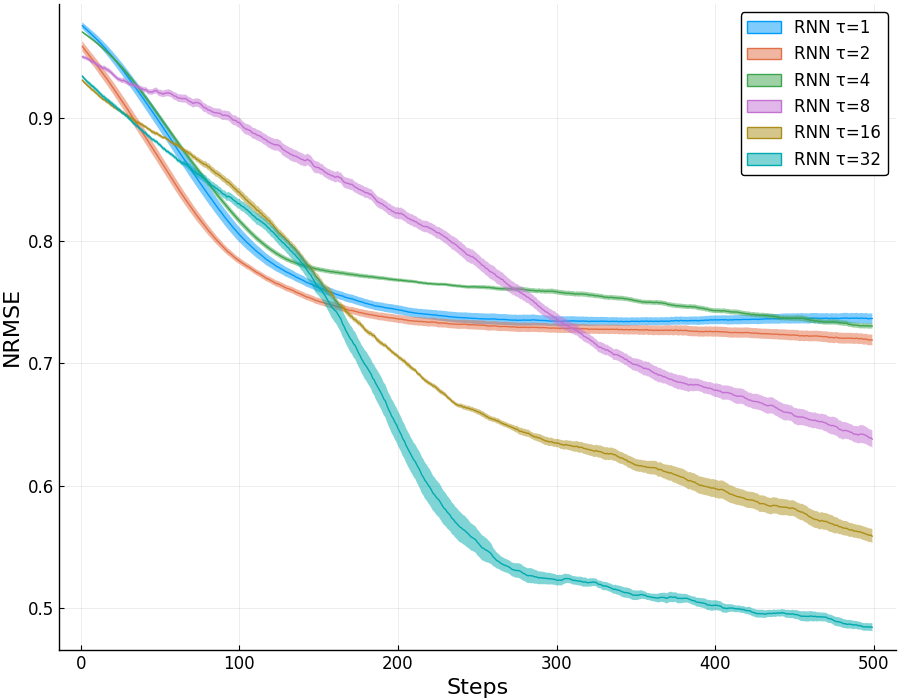

In [30]:
p = plot_best_settings(RNNSpec(rnn_ic; window=10))
plot(p, size = (900,700))